In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
import cftime

In [2]:
'''Import data for hillslope and SPRUCE'''
#Uncalibrated data
SPRUCEuncalib = xr.open_mfdataset('ELM-SPRUCE/initRUN/TEST_US-SPR_ICB20TRCNPRDCTCBC/run/TEST_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalib = xr.open_mfdataset('CLM-hillslope/4col-original/initRUNS_long/test-hillslope-mct-srof.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

In [3]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[(dt1.DATE.dt.year > 2010) & (dt1.DATE.dt.year < 2017)]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)
wte['WTD'] = -(422.0 - wte.WTE)

In [4]:
'''Load calibration Streamflow data'''
dt2 =pd.read_csv('./Streamflow_daily.csv', skiprows = 1, sep = ",",
                 names = ["Date", "Watershed", "Q_Ls" , "Q_cfs", "Q_cmday"],
                 parse_dates=['Date'],
                 na_values={'Q_cfs':['NA',], 'Q_Ls':['NA',], 'Q_cmday':['NA',],})

dt2.Watershed=dt2.Watershed.astype('category') 

# Pull out calibration year
stream = dt2[(dt2.Date.dt.year > 2010) & (dt2.Date.dt.year < 2017)]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)
stream['Q_mms'] = stream.Q_cmday*(10/(24*60*60))

In [3]:
'''Subset years'''
SPRUCEuncalib = SPRUCEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalib = HILLSLOPEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))

In [4]:
HILLSLOPEuncalib

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         time: 2190, column: 4, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 4)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2011-01-01 00:00:00 ... 2016-12-31 00:0...
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/82)
    hslp_distance       (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    hslp_width          (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    hslp_area           (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    hslp_elev           (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    hslp_slope          (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    hslp_aspect         (time, column) float64 dask.array<chunksize=(365, 4), meta=np.ndarray>
    ...                  ...
    TREFMNAV            (time, pft) float32 dask.array<chunksize=(365, 4), meta=np.ndarray>
    TREFMXAV            (time, pft) float32 dask.array<chunksize=(365, 4), meta=np.ndarray>
    TSA                 (time, pft) float32 dask.array<chunksize=(365, 4), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 4), meta=np.ndarray>
    ZWT                 (time, column) float32 dask.array<chunksize=(365, 4), meta=np.ndarray>
    ZWT_PERCH           (time, column) float32 dask.array<chunksize=(365, 4), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/25/23 12:17:59
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

In [5]:
HILLSLOPEuncalib.hslp_elev.values

array([[0.25784712, 0.71081055, 2.64757617, 6.0576271 ],
       [0.25784712, 0.71081055, 2.64757617, 6.0576271 ],
       [0.25784712, 0.71081055, 2.64757617, 6.0576271 ],
       ...,
       [0.25784712, 0.71081055, 2.64757617, 6.0576271 ],
       [0.25784712, 0.71081055, 2.64757617, 6.0576271 ],
       [0.25784712, 0.71081055, 2.64757617, 6.0576271 ]])

In [6]:
SPRUCEuncalib

<xarray.Dataset>
Dimensions:                   (levgrnd: 15, levlak: 10, levdcmp: 15,
                               time: 2190, hist_interval: 2, lndgrid: 2,
                               ltype: 9, natpft: 17)
Coordinates:
  * levgrnd                   (levgrnd) float32 0.007101 0.02792 ... 21.33 35.18
  * levlak                    (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                   (levdcmp) float32 0.007101 0.02792 ... 21.33 35.18
  * time                      (time) object 2011-01-01 00:00:00 ... 2016-12-3...
Dimensions without coordinates: hist_interval, lndgrid, ltype, natpft
Data variables: (12/541)
    mcdate                    (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mcsec                     (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mdcur                     (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mscur                     (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    nstep                     (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    time_bounds               (time, hist_interval) object dask.array<chunksize=(365, 2), meta=np.ndarray>
    ...                        ...
    cn_scalar                 (time, lndgrid) float32 dask.array<chunksize=(365, 2), meta=np.ndarray>
    cp_scalar                 (time, lndgrid) float32 dask.array<chunksize=(365, 2), meta=np.ndarray>
    leaf_npimbalance          (time, lndgrid) float32 dask.array<chunksize=(365, 2), meta=np.ndarray>
    nlim_m                    (time, lndgrid) float32 dask.array<chunksize=(365, 2), meta=np.ndarray>
    o2_decomp_depth_unsat     (time, levgrnd, lndgrid) float32 dask.array<chunksize=(365, 15, 2), meta=np.ndarray>
    plim_m                    (time, lndgrid) float32 dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes: (12/25)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/07/23 16:54:09
    source:                                    Community Land Model CLM4.0
    hostname:                                  ubuntu
    ...                                        ...
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    Time_constant_3Dvars_filename:             ./TEST_US-SPR_ICB20TRCNPRDCTCB...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [7]:
SPRUCEuncalib.ZWT.values

array([[0.16413562, 0.03107977],
       [0.16259266, 0.02844707],
       [0.16351523, 0.03308582],
       ...,
       [0.13746613, 0.00093841],
       [0.13743483, 0.00093841],
       [0.13779953, 0.00093841]], dtype=float32)

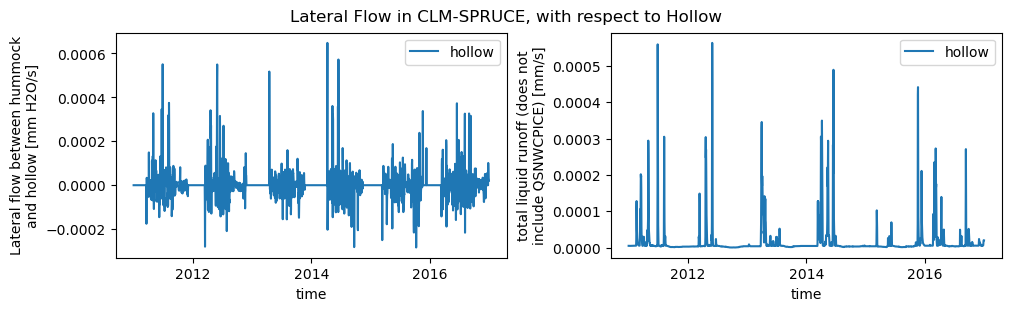

In [31]:
#lndgrid 0 = Hummock, lndgrid 1 = Hollow
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 3), 
                               constrained_layout = True)
a = SPRUCEuncalib.QFLX_LAT_AQU.isel(lndgrid=[1]).plot.line(x = 'time', ax = ax1)
ax1.legend({'hollow' : a})
b = SPRUCEuncalib.QRUNOFF.isel(lndgrid=[1]).plot.line(x = 'time', ax = ax2)
ax2.legend({'hollow' : b})
plt.suptitle('Lateral Flow in CLM-SPRUCE, with respect to Hollow')
plt.show()

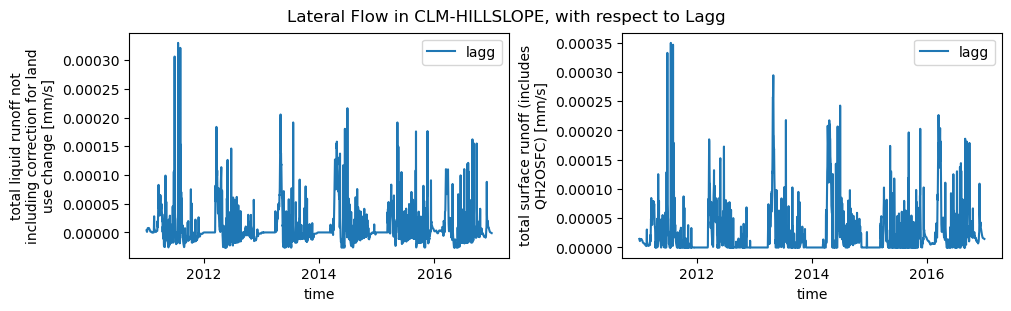

In [18]:
#column 0 = Lagg, column 1 = Bog, column 2 = Lagg/Upland, column 3 = Upland

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 3), 
                               constrained_layout = True)
a = HILLSLOPEuncalib.QRUNOFF.isel(column=[0]).plot.line(x = 'time', ax = ax1)
ax1.legend({'lagg' : a})
b = HILLSLOPEuncalib.QOVER.isel(column=[0]).plot.line(x = 'time', ax = ax2)
ax2.legend({'lagg' : b})
plt.suptitle('Lateral Flow in CLM-HILLSLOPE, with respect to Lagg')
plt.show()

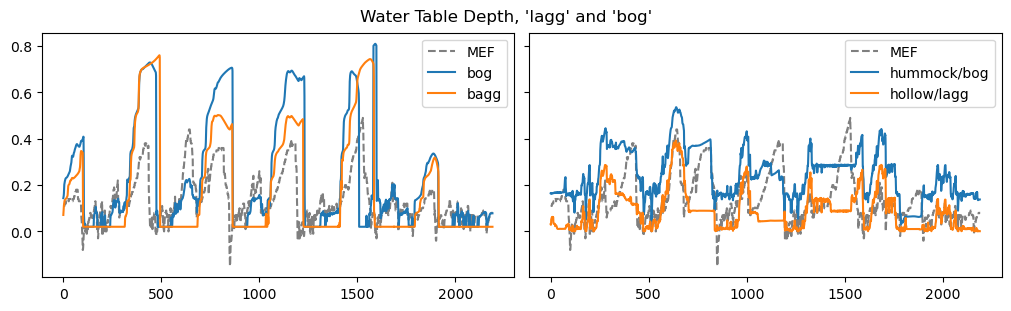

In [63]:
#Hillslope and SPRUCE water table elevations
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 3),
                               sharey = True,
                               constrained_layout = True)
m = ax1.plot(-wte.WTD, '--k', alpha = 0.5, label = 'MEF')
a = ax1.plot(HILLSLOPEuncalib.ZWT.isel(column=[1]), label = 'bog')
b = ax1.plot(HILLSLOPEuncalib.ZWT.isel(column=[0]), label = 'bagg')
ax1.legend()
m = ax2.plot(-wte.WTD, '--k', alpha = 0.5, label = 'MEF')
c = ax2.plot(SPRUCEuncalib.ZWT.isel(lndgrid=[0]), label = 'hummock/bog')
d = ax2.plot(SPRUCEuncalib.ZWT.isel(lndgrid=[1]), label = 'hollow/lagg')
ax2.legend()
plt.suptitle('Water Table Depth, \'lagg\' and \'bog\'')
plt.show()